In [12]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv, global_mean_pool, TopKPooling
from torch_geometric.data import Data,DataLoader
# from torch_geometric.loader import DataLoader
import torch.nn.functional as F
from torch_geometric.utils.convert import from_scipy_sparse_matrix
from torch_geometric.utils.convert import from_networkx
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat, savemat
import pandas as pd
import scipy.special as SS
import scipy.stats as SSA
import copy
import math
from sklearn.model_selection import ParameterGrid
import os
import numpy.linalg as LA
import gzip

from scipy import sparse

# load pickle module
import pickle
import networkx as nx
import torch.nn as nn
from torch.distributions import Normal

In [2]:
R0 = 2.5
rs = np.array([20, 10, 2.0, 1.0, 0.5, 0.2, 0.1, 0.05, 0.025])

In [3]:
WN = np.loadtxt('../W_avg.csv') ### numpy arrary

In [5]:
# Create a graph from mobility matrix
GM = nx.from_numpy_array(WN)
edges = np.array(GM.edges()).transpose()
edge_index = torch.tensor(edges,dtype = torch.int64)

In [6]:
def load_gzipped_numpy(filename):
    try:
        with gzip.open(filename, 'rb') as f:
            return np.load(f, allow_pickle=True)
    except FileNotFoundError:
        return [0]

In [7]:
export_dir = '/Users/qingyao/Documents/branching_data/simulation/python_cutoff/'
#### data preparation
dataset = []
r_class = {}
for r_idx in range(9):
    r = rs[r_idx]
    sub_export_dir = export_dir+'branching_R0-{}_r-{}/'.format(np.round(R0,2),np.round(r,3))
    print(r)
    # Create a list to hold our Data objects
    for g_idx in range(300):
        export_names = sub_export_dir+'NewInf_R0-{}_r-{}_{}.npy.gz'.format(np.round(R0,2),np.round(r,3),(g_idx+1))
        g_i = load_gzipped_numpy(export_names)
        g_i[g_i == 0] = 0.0000001 ### use the log to make the pattern more obvious
        Z = np.log(g_i[:,10:]) ### previous are almost 0
        matrix = torch.from_numpy(g_i[:,10:])
        y = torch.tensor([r_idx], dtype=torch.long)
        # Create a Data object for each graph
        data = Data(x=matrix, edge_index=edge_index, y=y)
#         data = Data(x=ma_normalized, edge_index=edge_index, y=y)
        data.x = data.x.float()
        data.y = data.y.long()
        # Add the Data object to our list
        dataset.append(data)

20.0
10.0
2.0
1.0
0.5
0.2
0.1
0.05
0.025


In [8]:
from torch.utils.data import random_split
train_data, test_data = random_split(dataset, [1800, 900])

In [ ]:
import pyro
import pyro.distributions as dist

In [20]:
class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features

        # Prior distributions for weights and biases
        self.weight_prior = dist.Normal(loc=torch.zeros(out_features, in_features).to(device), scale=torch.ones(out_features, in_features).to(device))
        self.bias_prior = dist.Normal(loc=torch.zeros(out_features).to(device), scale=torch.ones(out_features).to(device))
        
        # Variational parameters
        self.weight_mu = nn.Parameter(torch.zeros(out_features, in_features).to(device))
        self.weight_logvar = nn.Parameter(torch.zeros(out_features, in_features).to(device))
        self.bias_mu = nn.Parameter(torch.zeros(out_features).to(device))
        self.bias_logvar = nn.Parameter(torch.zeros(out_features).to(device))

    def forward(self, x):
        # Sample weights and biases from their distributions
        weight = pyro.sample("weight", dist.Normal(self.weight_mu, torch.exp(self.weight_logvar)).to_event(2))
        bias = pyro.sample("bias", dist.Normal(self.bias_mu, torch.exp(self.bias_logvar)).to_event(1))
        return F.linear(x, weight, bias)

    
class BayesianGCN(nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(BayesianGCN, self).__init__()
        
        # Here, for simplicity, I'm replacing GCNConv with BayesianLinear
        # For real-world usage, a Bayesian version of GCNConv would be needed
        self.conv1 = BayesianLinear(num_node_features, 128)
        self.conv2 = BayesianLinear(128, 128)
        self.conv3 = BayesianLinear(128, 64)
        
        self.classifier = BayesianLinear(64, num_classes)
        
    def forward(self, data):
        x = data.x  # Extract node features from the DataBatch
        batch = data.batch  # Extract batch information from the DataBatch

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # Use the batch information for global mean pooling
        x = global_mean_pool(x, batch)

        x = self.classifier(x)

        return x

# KL Divergence Loss
def kl_divergence(layer):
    # Compute KL divergence between q and p
    kl_weight = torch.distributions.kl_divergence(dist.Normal(layer.weight_mu, torch.exp(layer.weight_logvar)), layer.weight_prior).sum()
    kl_bias = torch.distributions.kl_divergence(dist.Normal(layer.bias_mu, torch.exp(layer.bias_logvar)), layer.bias_prior).sum()
    return kl_weight + kl_bias


def train_bayesian():
    model.train()
    loss_all = 0
    correct = 0
    total = 0
    for data in myloader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        label = data.y.to(device)
        
        # Cross entropy loss
        loss = F.cross_entropy(output, label)
        
        # Accumulate KL divergence for each layer
        total_kl = 0
        for layer in model.children():
            if isinstance(layer, BayesianLinear):
                total_kl += kl_divergence(layer)
        
        # Add KL divergence to the loss
        loss += total_kl
        
        loss.backward()
        loss_all += data.num_graphs * loss.item()
        optimizer.step()
        _, predicted = torch.max(output, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()
        
    accuracy = 100 * correct / total
    return loss_all / len(myloader.dataset), accuracy



# Now we can create a DataLoader
myloader = DataLoader(train_data, batch_size=64, shuffle=True)
# Create a model and an optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BayesianGCN(num_node_features=50, num_classes=9).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Now, you can call your training function
loss_ep = []
ac_ep = []
for epoch in range(100):
    loss, ac = train_bayesian()
    loss_ep.append(loss)
    ac_ep.append(ac)
    print('Epoch: {:03d}, Loss: {:.5f}, ac: {:.5f}'.format(epoch, loss, ac))

Epoch: 000, Loss: 83344.30875, ac: 11.55556
Epoch: 001, Loss: 55615.10115, ac: 11.83333
Epoch: 002, Loss: 51359.02455, ac: 12.38889
Epoch: 003, Loss: 45370.36253, ac: 9.72222
Epoch: 004, Loss: 30116.31448, ac: 10.05556
Epoch: 005, Loss: 26594.48196, ac: 10.38889
Epoch: 006, Loss: 21842.85220, ac: 10.61111
Epoch: 007, Loss: 20482.26776, ac: 9.44444
Epoch: 008, Loss: 19528.71437, ac: 10.27778
Epoch: 009, Loss: 16538.37113, ac: 10.05556
Epoch: 010, Loss: 14326.44845, ac: 11.88889
Epoch: 011, Loss: 12525.72839, ac: 12.33333
Epoch: 012, Loss: 11834.31615, ac: 12.11111
Epoch: 013, Loss: 9716.18185, ac: 11.44444
Epoch: 014, Loss: 8697.06898, ac: 11.77778
Epoch: 015, Loss: 9012.44767, ac: 12.16667
Epoch: 016, Loss: 7763.34939, ac: 11.44444
Epoch: 017, Loss: 9161.72635, ac: 11.05556
Epoch: 018, Loss: 7452.98910, ac: 11.66667
Epoch: 019, Loss: 6819.46709, ac: 10.94444
Epoch: 020, Loss: 7121.69985, ac: 11.55556
Epoch: 021, Loss: 5441.38684, ac: 11.00000
Epoch: 022, Loss: 6140.05556, ac: 10.61111


Text(0, 0.5, 'Loss')

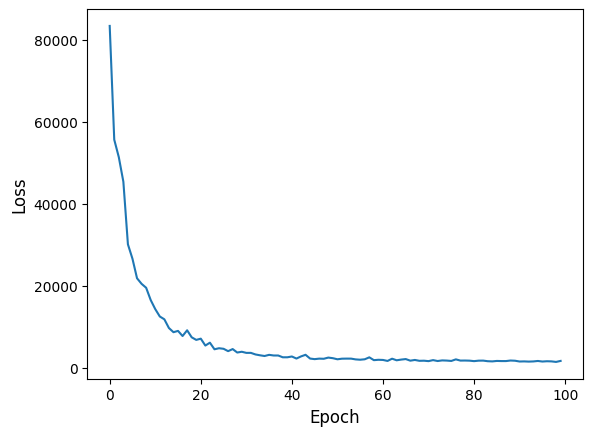

In [21]:
plt.plot(loss_ep)
# plt.plot(ac_ep,color='green')
plt.xlabel('Epoch',size=12)
# plt.ylabel('Accuracy')
plt.ylabel('Loss',size=12)


In [53]:
len(dataset)

2700

In [22]:
# Example unseen graph data (make sure it's similar to your training data in structure)
# unseen_data = [dataset[1], dataset[310], dataset[660], dataset[1000]]  # Replace with your actual graph data

# Convert to DataLoader
unseen_loader = DataLoader(test_data, batch_size=32)  # Adjust batch size as needed

# Function for prediction
def predict(loader):
    model.eval()  # Set model to evaluation mode
    predictions = []

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            output = model(data)
            _, predicted_class = output.max(dim=1)
#             predicted_class = torch.argmax(output, dim=1)
            predictions.extend(predicted_class.cpu().numpy().tolist())

    return predictions

# Get predictions
predicted_classes = predict(unseen_loader)
# print(predicted_classes)


In [23]:
correct = 0
total = 0
y_test = []
# ac = []
for i in range(len(test_data)):
    data_i = test_data[i]
    predicted =  predicted_classes[i]
    label = data_i.y.to(device)
    total += label.size(0)  # Change "labels" to "label"
    correct += (predicted == label).sum().item()
    y_test.append(label)# Change "labels" to "label"
accuracy = 100 * correct / total

In [24]:
accuracy

11.0

In [73]:
fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2
n_classes = 9
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

ValueError: multiclass format is not supported

In [35]:
import torch

# Save:
torch.save(model.state_dict(), 'model_path.pt')

# Load:
model1 = GCN(50,9)  # Initialize your model architecture
model1.load_state_dict(torch.load('model_path.pt'))
model1.eval()  # Set in evaluation mode

GCN(
  (conv1): GCNConv(50, 128)
  (conv2): GCNConv(128, 64)
  (classifier): Linear(in_features=64, out_features=9, bias=True)
)

In [37]:
model1.eval()  # Set model to evaluation mode
predictions = []

with torch.no_grad():
    for data in unseen_loader:
        data = data.to(device)
        output = model1(data)
        predicted_class = torch.argmax(output, dim=1)
        predictions.extend(predicted_class.cpu().numpy().tolist())

In [38]:
predictions

[0, 1, 2, 3]

In [ ]:
# Example single graph data
single_graph = Data(...)  # Replace with your actual graph data

# Move data to device
single_graph = single_graph.to(device)

# Function for prediction on a single graph
def predict_single(graph):
    model.eval()  # Set model to evaluation mode

    with torch.no_grad():
        output = model(graph)
        predicted_class = torch.argmax(output, dim=1)

    return predicted_class.item()  # Convert tensor to Python scalar

# Get prediction
predicted_class = predict_single(single_graph)
print(predicted_class)
